# **Predicting 30-Day Hospital Readmission in Diabetic Patients**

## Introduction

The *Diabetes 130-US hospitals for years 1999–2008* dataset, publicly available through the UC Irvine Machine Learning Repository, is a clinical dataset compiled from over 130 hospitals and integrated healthcare systems in the United States.

It contains detailed information on 101766 inpatient encounters involving diabetic patients over a nine-year period. The primary objective of the dataset is to facilitate the analysis and prediction of hospital readmission among diabetic populations, that is a critical challenge in modern healthcare due to its impact on healthcare costs, quality of care, and patient outcomes.

The dataset consists of two main files:
1. **diabetic_data.csv**: 50 variables describing patient demographics, diagnoses, procedures, laboratory results, and medications.
2. **IDs_mapping.csv**: a mapping file that translates coded variables (such as admission_type_id, discharge_disposition_id, and admission_source_id) into human-readable descriptions.

Each row represents a single hospital encounter, not a unique patient — a crucial detail that introduces potential data leakage if not handled properly during train-test splitting.

In addition, the dataset presents several challenges typical of real-world clinical data:
* Missing values and placeholder symbols;
* High-cardinality categorical variables;
* Encoded medical information;
* Strong class imbalance in the readmission outcome.

Despite these challenges, the dataset provides a rich framework for evaluating supervised learning algorithms, exploring feature importance, and understanding the limits of predictive modeling in healthcare contexts.

**Dataset source**: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008


# Data preprocessing

The dataset required extensive preprocessing to ensure data quality, prevent data leakage, and make the variables suitable for machine learning models.

The preprocessing pipeline included the following steps:

1. **Mapping Encoded Identifiers**: The dataset contains numerical codes for *admission_type_id*, *discharge_disposition_id*, and *admission_source_id*.
These were mapped to human-readable categories using the provided mapping file (IDs_mapping.csv).
In addition, encounters corresponding to discharge dispositions incompatible with readmission prediction (e.g., death or hospice) were removed.
2. **Handling Missing Values**: Clinical datasets often contain placeholder symbols such as "*?*", "*Not Available*", or "*Unknown/Invalid*".
These were converted to *NaN* and managed as follows: \
-Columns with excessive missing values (*weight*, *max_glu_serum*, *A1Cresult*, *payer_code*) were removed. \
-Categorical variables with limited missingness were filled with "*Other*" or "*Unknown*". \
-Rows with missing gender values were removed.
3. **Target Encoding**: The original readmitted variable has three categories:
"<30" for readmitted within 30 days, ">30" for readmitted after 30 or more days, and "NO" if there was not another readmission. \
For our binary classification, the target was encoded as: \
*readmitted_binary* = $1$ if "<30" else $0$. \
This reframed the problem as predicting 30-day readmission.
4. **Feature Engineering**: Several transformations were applied: \
-Age: Ordinal age ranges mapped to numerical categories. \
-Gender: Binary encoding (Female=1, Male=0). \
-Race & Medical Specialty: One-hot encoding, retaining most frequent categories. \
-Medications: Ordinal encoding (No=0, Down=1, Steady=2, Up=3). \
-Diagnosis codes (ICD-9): Grouped into clinically meaningful macro-categories. \
This reduced high-cardinality diagnosis codes into interpretable disease groups.
5. **Final Dataset**: after preprocessing encoded categorical variables using one-hot encoding, removed identifier columns, and obtained a fully numeric feature matrix suitable for machine learning models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import csv file
diabete = pd.read_csv("diabetic_data.csv")

# ##########################################
# Dataset Union
# ##########################################
with open("IDS_mapping.csv", "r") as f:
    lines = f.readlines()
# Isolate relevant blocks based on file structure
admission_lines = lines[1:9]
discharge_lines = lines[11:41]
source_lines = lines[43:]

# Function to create a dictionary ignoring 'NULL' descriptions
def parse_lines_to_dict(block_lines):
    mapping = {}
    for line in block_lines:
        if ',' in line:
            parts = line.strip().split(',', 1)
            if parts[0].strip().isdigit():
                descr = parts[1].strip()
                if descr != 'NULL':
                    mapping[int(parts[0])] = descr
    return mapping

admission_map = parse_lines_to_dict(admission_lines)
discharge_map = parse_lines_to_dict(discharge_lines)
source_map = parse_lines_to_dict(source_lines)

# Apply substitution in the DataFrame
diabete['admission_type'] = diabete['admission_type_id'].map(admission_map)
diabete['discharge_disposition'] = diabete['discharge_disposition_id'].map(discharge_map)
diabete['admission_source'] = diabete['admission_source_id'].map(source_map)

discharge_ids_to_remove = [11, 13, 14, 19, 20, 21]
# Get the corresponding 'discharge_disposition' values from the discharge_map
discharge_values_to_remove = [discharge_map[id] for id in discharge_ids_to_remove if id in discharge_map]
# Remove rows where 'discharge_disposition' is in the list of values to remove
diabete = diabete[~diabete['discharge_disposition'].isin(discharge_values_to_remove)].copy()
print("Shape of diabete_adj after removing specified discharge dispositions:", diabete.shape)

# Delete the original ID columns
diabete = diabete.drop(columns=[
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'
])

# Keep only the first admission per patient
#diabete = diabete.sort_values(by=['patient_nbr', 'encounter_id'])
#diabete = diabete.drop_duplicates(subset='patient_nbr', keep='first')
#print("Prendendo solo il primo ricovero per pz:", diabete.shape)

######################################################
# REPLACE
######################################################
diabete.replace('?', np.nan, inplace=True)
diabete.replace("Not Available", np.nan, inplace=True)
diabete.replace("Unknown/Invalid", np.nan, inplace=True)
diabete.replace("Not Mapped", np.nan, inplace=True)

# ###################################################################
# HANDLING MISSING VALUES
# ###################################################################

# It is definitely worth removing columns that have a high number of missing values
diabete_adj = diabete.drop(columns=['weight', 'max_glu_serum', 'A1Cresult'])

diabete_adj = diabete_adj.drop(columns=['payer_code'])

# keeping medical specialty instead, replacing the values
diabete_adj['medical_specialty'] = diabete_adj['medical_specialty'].fillna('Other')

# We now manage columns with few missing values
diabete_adj['admission_type'] = diabete_adj['admission_type'].fillna('Unknown')
diabete_adj['discharge_disposition'] = diabete_adj['discharge_disposition'].fillna('Unknown')
diabete_adj['admission_source'] = diabete_adj['admission_source'].fillna('Unknown')
diabete_adj['diag_1'] = diabete_adj['diag_1'].fillna('Unknown')
diabete_adj['diag_2'] = diabete_adj['diag_2'].fillna('Unknown')
diabete_adj['diag_3'] = diabete_adj['diag_3'].fillna('Unknown')
# Replacing missing values with 'other' for the 'race' column
diabete_adj['race']=diabete_adj['race'].fillna('Other')
# removing rows whose gender value is nan
diabete_adj.dropna(subset=['gender'], inplace=True)
print("Shape of diabete_adj after removing rows with NaN in 'gender':", diabete_adj.shape)

#########################################################################
# 'Readmitted' encoding in binary
#########################################################################
diabete_adj['readmitted_binary'] = diabete_adj['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

diabete_adj.drop(columns=['encounter_id', 'readmitted'], inplace=True)

df_clean = diabete_adj.copy()

#######################################################################
# Conversion
#######################################################################
age_map = {
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3,
    '[40-50)': 4, '[50-60)': 5, '[60-70)': 6,
    '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
}

df_clean['age'] = diabete_adj['age'].map(age_map)
print(df_clean['age'].unique())

numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'age'
]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean = pd.get_dummies(df_clean, columns=['race'], prefix='race', drop_first=False)
df_clean.drop(columns=['race_Other'], inplace=True)

df_clean['gender'] = df_clean['gender'].map({'Female': 1, 'Male': 0})

top_specialties = df_clean['medical_specialty'].value_counts().nlargest(10).index
df_clean['medical_specialty'] = df_clean['medical_specialty'].apply(lambda x: x if x in top_specialties else 'Other')
df_clean = pd.get_dummies(df_clean, columns=['medical_specialty'], drop_first=False)
df_clean = df_clean.drop(columns=['medical_specialty_Other'])

drug_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]
drug_map = {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3}
for col in drug_cols:
    df_clean[col] = df_clean[col].map(drug_map)

df_clean['change'] = df_clean['change'].map({'No': 0, 'Ch': 1})
df_clean['diabetesMed'] = df_clean['diabetesMed'].map({'No': 0, 'Yes': 1})

# Descriptive encoding for admission_type, discharge_disposition, admission_source
for col in ['admission_type', 'discharge_disposition', 'admission_source']:
    df_clean[col] = df_clean[col].fillna('Unknown')
    df_clean = pd.get_dummies(df_clean, columns=[col], prefix=col, drop_first=False )

df_clean.drop(columns = ['admission_type_Unknown', 'discharge_disposition_Unknown', 'admission_source_Unknown'], inplace=True)

# Diagnosis in macro-groups ICD9
def map_diag(code):
    try:
        code = float(code)
        if 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif code == 250:
            return 'Diabetes'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 710 <= code <= 739:
            return 'Musculoskeletal'
        elif 580 <= code <= 629 or code == 788:
            return 'Genitourinary'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        else:
            return 'Other'
    except:
        if str(code).startswith('V') or str(code).startswith('E'):
            return 'Other'
        return 'Unknown'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df_clean[col] = df_clean[col].apply(map_diag)
    df_clean = pd.get_dummies(df_clean, columns=[col], prefix=col, drop_first=False)

df_clean.drop(columns = ['diag_1_Unknown', 'diag_2_Unknown', 'diag_3_Unknown' ], inplace=True)
df_clean.drop(columns = ['diag_1_Other', 'diag_2_Other', 'diag_3_Other' ], inplace=True)

Mounted at /content/drive
Shape of diabete_adj after removing specified discharge dispositions: (99343, 53)
Shape of diabete_adj after removing rows with NaN in 'gender': (99340, 46)
[0 1 2 3 4 5 6 7 8 9]


# Exploratory Analysis & Dimensionality Reduction

Before training predictive models, exploratory analyses were conducted to understand the intrinsic structure of the dataset and evaluate class separability.

PCA (Principal Component Analysis) was applied to evaluate whether linear combinations of features could separate readmitted patients from non-readmitted ones. \
The first principal components explained only the $31.51%$ portion of variance, and no clear class separation emerged when projecting data onto the first two components, and even onto the first three ones.

Next, t-SNE was used to explore potential non-linear structures.
The resulting embeddings showed overlapping clusters between classes, suggesting weak intrinsic separability of the target variable.

In addition, unsupervised clustering techniques were also tested to detect eventual structural groupings in the data. Silhouette scores remained consistently below $0.2$ across different values of $K$, indicating weak cluster cohesion and poor separation. Moreover, the identified clusters did not align meaningfully with readmission outcomes, suggesting that readmission risk is not driven by distinct patient profiles in the available feature space.

An additional intra-patient analysis showed high stability across multiple admissions: on average, approximately 97 out of 110 features remained unchanged between consecutive hospital encounters for the same patient. This limited variability further reduces the availability of new discriminative information for predicting short-term readmission.

Overall, these exploratory analyses consistently indicate limited intrinsic separability of the 30-day readmission outcome. The dataset appears to contain weak discriminatory structure, high feature sparsity due to one-hot encoding, and strong class imbalance, which are factors that collectively constrain the achievable predictive performance.

# Final Dataset Overview

Non-numeric columns in df_clean: Index([], dtype='object')
(99340, 112)
Distribution of 'readmitted_binary':
readmitted_binary
0    88026
1    11314
Name: count, dtype: int64


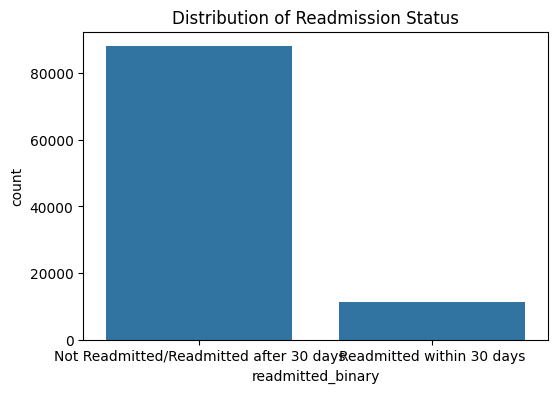

In [ ]:
# Checking non-numeric columns
non_numeric_cols = df_clean.select_dtypes(include=['object']).columns
print("Non-numeric columns in df_clean:", non_numeric_cols)

# verifica dimensione del dataset
print(df_clean.shape)

# Check the balance of the dataset by looking at the distribution of the target variable
readmitted_counts = df_clean['readmitted_binary'].value_counts()
print("Distribution of 'readmitted_binary':")
print(readmitted_counts)

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='readmitted_binary', data=df_clean)
plt.title('Distribution of Readmission Status')
plt.xticks([0, 1], ['Not Readmitted/Readmitted after 30 days', 'Readmitted within 30 days'])
plt.show()

## Target Distribution
As we can see in the previous graph, the distribution of the binary target variable shows a strong imbalance between readmitted and non-readmitted patients.

This imbalance is critical because standard classifiers may bias toward the majority class, accuracy alone would be misleading, and, in addition, recall, precision, F1-score, and AUC become more meaningful evaluation metrics.

# SPLIT

## Preventing Patient-Level Data Leakage

Each row in the dataset represents a hospital encounter, not a unique patient. Performing a standard row-wise train-test split could lead to the same patient appearing in both the training and test sets, which would introduce data leakage and artificially inflate model performance.

Initially, to prevent data leakage, we considered selecting only the first admission per patient (to avoid future information leaking into the training set) or only the last admission (to retain more recent patient information). However, after evaluating these options, the most sensible approach was to perform the split at the patient level, assigning all encounters of a given patient either to the training or to the test set, ensuring that no patient appears in both and without unnecessarily reduce the size of the dataset.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#######################################
# Preventing Patient-Level Data Leakage
#######################################

# separating feature from target (but keeping patient_nbr)
X = df_clean.drop(columns=["readmitted_binary"])
y = df_clean["readmitted_binary"]

patient_ids = X["patient_nbr"]

# unique patients list
unique_patients = patient_ids.unique()

# Split
train_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.2,
    random_state=42
)

train_mask = patient_ids.isin(train_patients)
test_mask = patient_ids.isin(test_patients)

X_train = X[train_mask].drop(columns=["patient_nbr"])
X_test = X[test_mask].drop(columns=["patient_nbr"])

y_train = y[train_mask]
y_test = y[test_mask]

# ensuring no patients are in both sets
intersection = set(train_patients).intersection(set(test_patients))
print("Overlap pazienti train-test:", len(intersection))

# Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Number of unique patients:")
print("Train:", len(train_patients))
print("Test:", len(test_patients))

print("\nNumber of encounters (rows):")
print("X_train:", X_train.shape[0])
print("X_test:", X_test.shape[0])

print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution (test):")
print(y_test.value_counts(normalize=True))

Overlap pazienti train-test: 0
Number of unique patients:
Train: 55989
Test: 13998

Number of encounters (rows):
X_train: 79454
X_test: 19886

Target distribution (train):
readmitted_binary
0    0.886425
1    0.113575
Name: proportion, dtype: float64

Target distribution (test):
readmitted_binary
0    0.884844
1    0.115156
Name: proportion, dtype: float64


# Model Selection

In the initial phase, we experimented with a variety of supervised learning algorithms, including:
Decision Tree, Random Forest, K-Nearest Neighbors (KNN), Support Vector Machines (SVM), Gradient Boosting, and XGBoost.  

After evaluating their baseline performance, we focused on the following three models for detailed analysis and reporting:

1. **Logistic Regression**, where scaling of features is applied to ensure proper convergence.

2. **Balanced Random Forest**, that is a "balanced" variant of "Random Forest" and it is specifically designed to handle imbalanced datasets by reweighting classes.

3. **XGBoost**.

These models were chosen to provide a mix of interpretability (logistic regression) and predictive power (tree-based models) while taking into account the highly imbalanced target variable.


Logistic Regression - Balanced
              precision    recall  f1-score   support

           0     0.9191    0.6879    0.7869     17596
           1     0.1824    0.5349    0.2720      2290

    accuracy                         0.6703     19886
   macro avg     0.5508    0.6114    0.5294     19886
weighted avg     0.8343    0.6703    0.7276     19886

AUC-ROC: 0.6656690782244078


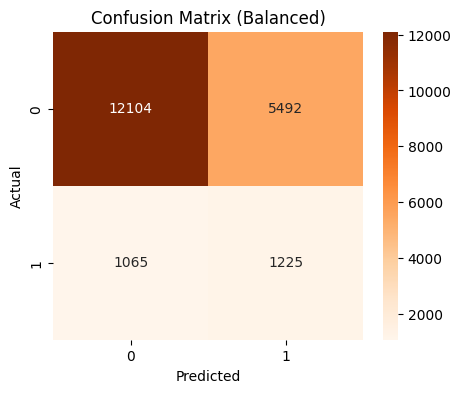

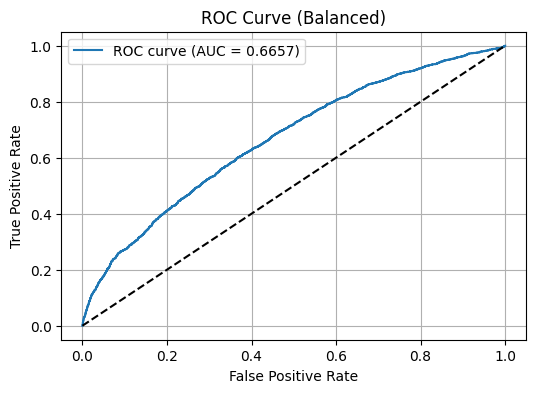

In [ ]:
# Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Model training with class_weight
lr_balanced = LogisticRegression(max_iter=1000, solver='saga', random_state=42, class_weight='balanced')
lr_balanced.fit(X_train_scaled, y_train)

# Prediction
y_pred_bal = lr_balanced.predict(X_test_scaled)
y_prob_bal = lr_balanced.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("Logistic Regression - Balanced")
print(classification_report(y_test, y_pred_bal, digits=4))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_bal))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_bal), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix (Balanced)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_prob_bal)
plt.figure(figsize=(6, 4))
plt.plot(fpr_bal, tpr_bal, label='ROC curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_prob_bal)))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Balanced)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9266    0.5886    0.7199     17596
           1     0.1688    0.6419    0.2673      2290

    accuracy                         0.5947     19886
   macro avg     0.5477    0.6153    0.4936     19886
weighted avg     0.8394    0.5947    0.6678     19886

=== Confusion Matrix ===
[[10357  7239]
 [  820  1470]]


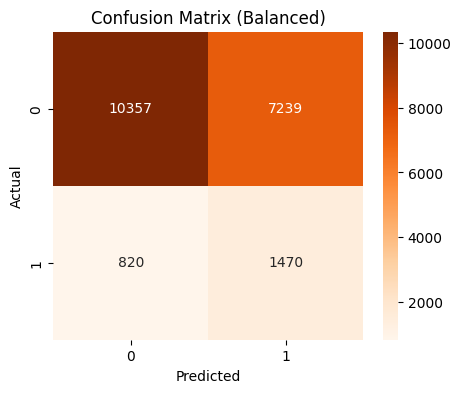

ROC AUC Score: 0.6617


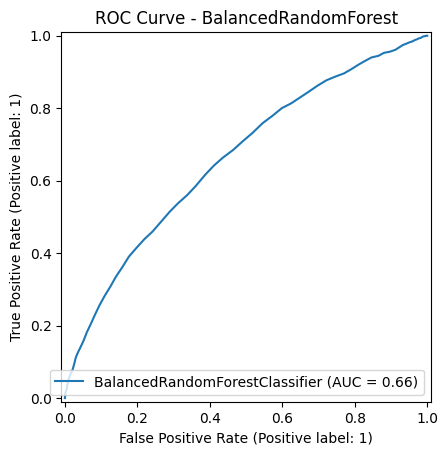

In [ ]:
# Balanced Random Forest

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    sampling_strategy='auto'  # automatically adjusts the sampling of each class to be equal when building the trees
)
brf.fit(X_train, y_train)

# Prediction
y_pred = brf.predict(X_test)
y_prob = brf.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix (Balanced)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# === ROC Curve ===
RocCurveDisplay.from_estimator(brf, X_test, y_test)
plt.title("ROC Curve - BalancedRandomForest")
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:07:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Balanced
              precision    recall  f1-score   support

           0     0.9159    0.7026    0.7952     17596
           1     0.1808    0.5044    0.2662      2290

    accuracy                         0.6798     19886
   macro avg     0.5484    0.6035    0.5307     19886
weighted avg     0.8313    0.6798    0.7343     19886

AUC-ROC: 0.6441167777313423


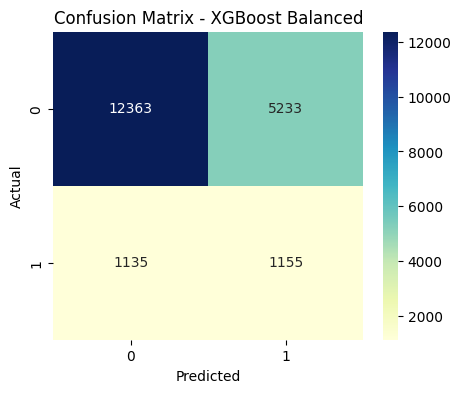

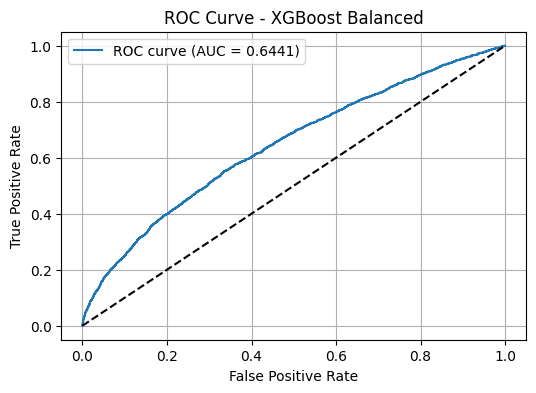

In [ ]:
# XGBoost (balanced with class weight)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

# scale_pos_weight = (#neg / #pos)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# training
xgb_balanced = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1
)
xgb_balanced.fit(X_train, y_train)

# Prediction
y_pred_xgb_bal = xgb_balanced.predict(X_test)
y_prob_xgb_bal = xgb_balanced.predict_proba(X_test)[:, 1]

# Classification report
print("XGBoost - Balanced")
print(classification_report(y_test, y_pred_xgb_bal, digits=4))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_xgb_bal))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_bal), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - XGBoost Balanced")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_xgb_bal, tpr_xgb_bal, _ = roc_curve(y_test, y_prob_xgb_bal)
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb_bal, tpr_xgb_bal, label='ROC curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_prob_xgb_bal)))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost Balanced")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### XGBoost with SMOTE

After implementing XGBoost using the '*scale_pos_weight*' parameter to address class imbalance, an additional experiment was conducted using SMOTE to oversample the minority class in the training set.

Contrary to expectations, applying SMOTE led to a deterioration in recall for the positive class. This suggests that synthetic oversampling may have introduced artificial patterns that do not generalize well to the test data. In particular, generating synthetic minority samples in a feature space characterized by high sparsity (due to extensive one-hot encoding) may distort the underlying structure rather than enhance meaningful signal.

These results indicate that internal class weighting (via '*scale_pos_weight*') is more appropriate for this dataset than synthetic resampling techniques.


Shape before SMOTE: (79454, 110) (79454,)
Shape after SMOTE: (140860, 110) (140860,)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [22:29:11] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost - with SMOTE
              precision    recall  f1-score   support

           0     0.8907    0.9269    0.9084     17596
           1     0.1829    0.1258    0.1490      2290

    accuracy                         0.8346     19886
   macro avg     0.5368    0.5263    0.5287     19886
weighted avg     0.8092    0.8346    0.8210     19886

AUC-ROC: 0.5933150373596222


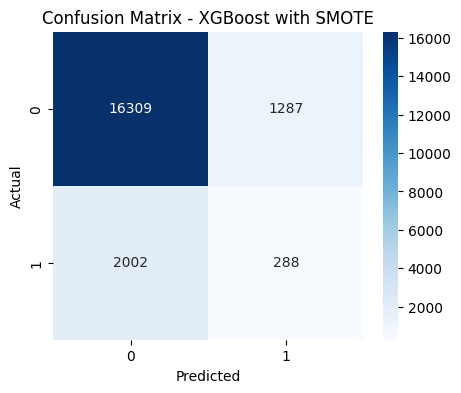

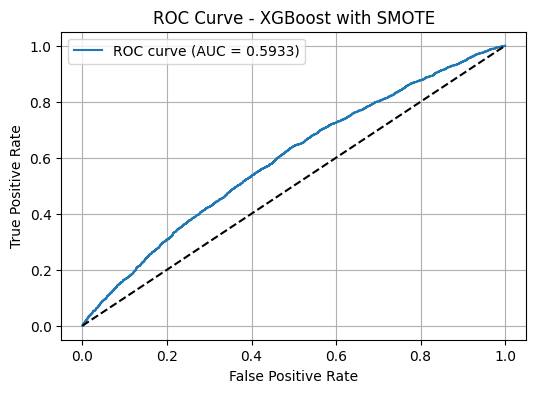

In [ ]:
# XGBoost (balanced with SMOTE)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Applying SMOTE only to the train set
print("Shape before SMOTE:", X_train.shape, y_train.shape)
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print("Shape after SMOTE:", X_train_smote.shape, y_train_smote.shape)

# Training
xgb_smote = XGBClassifier(
    use_label_encoder=False, # Deprecated warning suppression
    eval_metric='logloss', # Evaluation metric for binary classification
    random_state=42,
    n_jobs=-1
)
xgb_smote.fit(X_train_smote, y_train_smote)

# Prediction
y_pred_xgb_smote = xgb_smote.predict(X_test)
y_prob_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]

# Classification report
print("\nXGBoost - with SMOTE")
print(classification_report(y_test, y_pred_xgb_smote, digits=4))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_xgb_smote))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_smote), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost with SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_test, y_prob_xgb_smote)
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb_smote, tpr_xgb_smote, label='ROC curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_prob_xgb_smote)))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost with SMOTE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Neural Networks

To further investigate whether more complex non-linear patterns could improve predictive performance, we implemented a feedforward fully connected Neural Network.

The architecture consists of two hidden layers (64 and 32 neurons) with ReLU activation functions, followed by Dropout (0.3) to mitigate overfitting. The output layer uses a sigmoid activation function for binary classification. The model was optimized using the Adam optimizer and binary cross-entropy loss.

Given the strong class imbalance, class weights were computed and applied during training instead of oversampling, preserving the original data distribution while penalizing misclassification of the minority class.

Feature standardization was applied prior to training to ensure stable optimization and convergence. Early stopping based on validation loss was also implemented to prevent overfitting and retain the best-performing model.

Class weights: {0: np.float64(0.5640636092574187), 1: np.float64(4.4023714539007095)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5196 - loss: 0.7439 - val_accuracy: 0.5808 - val_loss: 0.6780
Epoch 2/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6002 - loss: 0.6686 - val_accuracy: 0.5982 - val_loss: 0.6813
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6221 - loss: 0.6590 - val_accuracy: 0.5897 - val_loss: 0.6729
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6251 - loss: 0.6479 - val_accuracy: 0.6061 - val_loss: 0.6638
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6254 - loss: 0.6488 - val_accuracy: 0.5926 - val_loss: 0.6610
Epoch 6/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6092 - loss: 0.6526 - val_accuracy: 0.5760 - val_loss: 0.6752
Epoch 7/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6264 - loss: 0.6411 - val_accuracy: 0.5921 - val_loss: 0.6643
Epoch 8/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6131 - loss: 0.6437 - val_accuracy: 0.

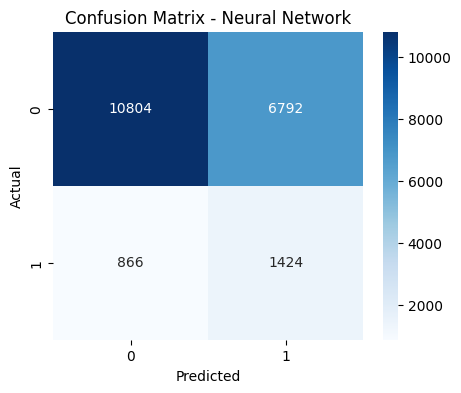

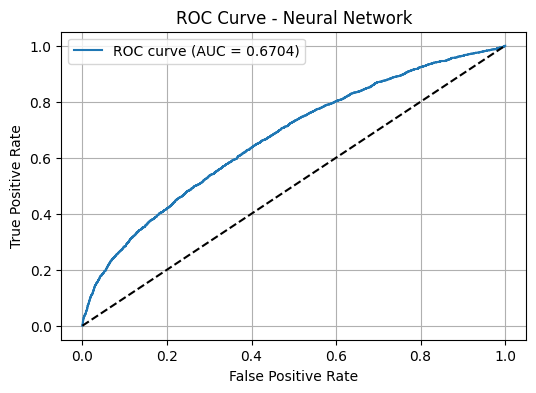

In [ ]:
# Neural Network Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Class Weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weights)

# model
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # output binario
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_prob_nn = model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_prob_nn >= 0.5).astype(int)

# Classification report
print("\nNeural Network - Classificazione")
print(classification_report(y_test, y_pred_nn, digits=4))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob_nn))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_prob_nn)
plt.figure(figsize=(6, 4))
plt.plot(fpr_nn, tpr_nn, label='ROC curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_pred_prob_nn)))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# Model Performance Comparison

In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Balanced Random Forest",
        "Logistic Regression (Balanced)",
        "XGBoost (Balanced)",
        "XGBoost (SMOTE)",
        "Neural Networks"
    ],
    "Precision (Class 1)": [0.1688, 0.1824, 0.1808, 0.1829, 0.1733],
    "Recall (Class 1)": [0.6419, 0.5349, 0.5044, 0.1258, 0.6218],
    "F1-Score (Class 1)": [0.2673, 0.2720, 0.2662, 0.1490, 0.2711],
    "AUC-ROC": [0.6617, 0.6657, 0.6441, 0.5933, 0.6703]
})

results


,Model,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),AUC-ROC
0,Balanced Random Forest,0.1688,0.6419,0.2673,0.6617
1,Logistic Regression (Balanced),0.1824,0.5349,0.2720,0.6657
2,XGBoost (Balanced),0.1808,0.5044,0.2662,0.6441
3,XGBoost (SMOTE),0.1829,0.1258,0.1490,0.5933
4,Neural Networks,0.1733,0.6218,0.2711,0.6703


The comparative results show modest predictive performance across all models.

**AUC-ROC** \
The Neural Network achieved the highest AUC (0.6703), closely followed by Logistic Regression (0.6657) and Balanced Random Forest (0.6617).  
However, the differences are marginal, suggesting limited overall discriminative power.

**Recall (Class 1, 30-day readmission)** \
Balanced Random Forest (0.6419) and Neural Network (0.6218) achieved the highest recall, capturing a larger proportion of true readmissions.  
This indicates that more flexible models tend to prioritize sensitivity toward the minority class.

**Precision** \
Precision remains consistently low across all models (~0.17-0.18).  
This implies that a large proportion of predicted readmissions are false positives, and it is a direct consequence of strong class imbalance and weak separability in the feature space.

**F1-Score** \
F1-scores remain clustered around 0.26–0.27, confirming that improvements in recall often come at the cost of precision.

**SMOTE Impact** \
XGBoost with SMOTE significantly underperformed (AUC 0.5933).  
This suggests that synthetic oversampling may distort the underlying data distribution rather than enhance meaningful signal extraction in this dataset.

From a clinical perspective, 30-day readmission is likely influenced by factors not fully captured in the dataset (e.g., socioeconomic status, outpatient follow-up quality, adherence to treatment, hospital discharge planning).


# Advanced Optimization Experiments

Several additional strategies were explored to improve recall for 30-day readmissions:

1. **Grid Search Hyperparameter Tuning**  
   Hyperparameters for the best-performing model (Balanced Logistic Regression) were optimized using recall as the target metric.
2. **Feature Selection**  
   Recursive feature elimination and importance-based selection were tested to reduce noise and improve generalization.
3. **Threshold Optimization**  
   the decision threshold was optimized instead of using the default value of 0.5.

Following, we show and analyze the results.


In [ ]:
# GRID SEARCH HYPERMARAMETER TUNING

from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import make_scorer, recall_score

# Define parameter grid for BalancedRandomForestClassifier
param_grid_brf = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create a custom scorer for recall of class 1 (positive class)
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=BalancedRandomForestClassifier(random_state=42),
    param_grid=param_grid_brf,
    scoring=recall_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

best_brf = BalancedRandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_features=grid_search.best_params_['max_features'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42,
    n_jobs=-1,
    sampling_strategy='auto'
)
best_brf.fit(X_train, y_train)

Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best recall score:  0.5969636524822696


=== Classification Report (Best BRF) ===
              precision    recall  f1-score   support

           0     0.9279    0.5985    0.7277     17596
           1     0.1724    0.6428    0.2719      2290

    accuracy                         0.6036     19886
   macro avg     0.5502    0.6206    0.4998     19886
weighted avg     0.8409    0.6036    0.6752     19886

=== Confusion Matrix (Best BRF) ===
[[10531  7065]
 [  818  1472]]


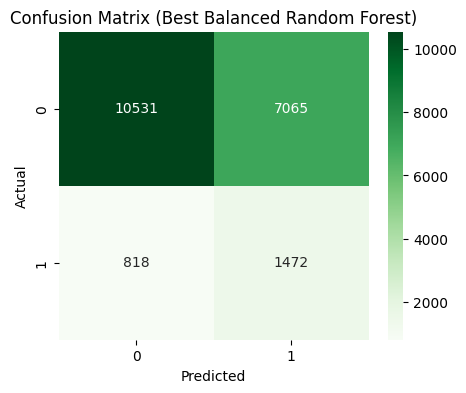

ROC AUC Score (Best BRF): 0.6698


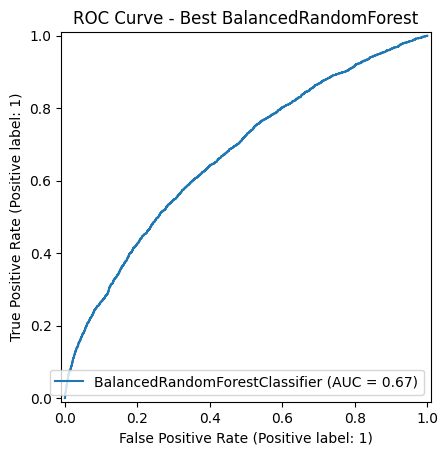

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Making predictions on the test set
y_pred_best_brf = best_brf.predict(X_test)
y_prob_best_brf = best_brf.predict_proba(X_test)[:, 1]

# Classification report
print("=== Classification Report (Best BRF) ===")
print(classification_report(y_test, y_pred_best_brf, digits=4))

# Confusion Matrix
print("=== Confusion Matrix (Best BRF) ===")
cm_best_brf = confusion_matrix(y_test, y_pred_best_brf)
print(cm_best_brf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_best_brf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Best Balanced Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate and print ROC AUC Score
roc_auc_best_brf = roc_auc_score(y_test, y_prob_best_brf)
print(f"ROC AUC Score (Best BRF): {roc_auc_best_brf:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_brf, X_test, y_test)
plt.title("ROC Curve - Best BalancedRandomForest")
plt.show()

A total of 48 hyperparameter combinations were evaluated through 3-fold cross-validation, resulting in 144 model fits.

The best cross-validation recall achieved during the grid search was 0.5969.

The best configuration identified was:

*max_depth*: 10  
*max_features*: 'sqrt'  
*min_samples_leaf*: 2  
*min_samples_split*: 5  
*n_estimators*: 100  

When evaluated on the independent test set, the optimized model achieved a recall of 0.6428 for the positive class.

Although recall slightly improved compared to the baseline configuration, overall performance gains were marginal.

The model maintains high sensitivity but continues to suffer from very low precision, meaning that a large number of non-readmitted patients are incorrectly classified as high risk.

The AUC-ROC (0.6698) remains within the same performance range observed across other experiments, suggesting that hyperparameter tuning alone cannot substantially enhance predictive performance.

These findings reinforce the hypothesis that the main limitation is not suboptimal model configuration, but rather the intrinsic predictive signal contained in the dataset.

Optimizing for recall increases the model’s ability to detect high-risk patients, but at the cost of clinical usability due to excessive false positives.


In [ ]:
#FEATURE SELECTION

from sklearn.feature_selection import SelectFromModel

# Create a selector object with the best_brf model and a median threshold
sf = SelectFromModel(best_brf, threshold='median', prefit=True)

# Transform the training and test data
X_train_selected = sf.transform(X_train)
X_test_selected = sf.transform(X_test)

# Get the names of the selected features
selected_feature_indices = sf.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices].tolist()

print(f"Number of features before selection: {X_train.shape[1]}")
print(f"Number of features after selection: {X_train_selected.shape[1]}")

# Get feature importances from the best_brf model
feature_importances = best_brf.feature_importances_

# Create a pandas Series for easier sorting and selection
importance_series = pd.Series(feature_importances, index=X_train.columns)

# Get the top 10 most important features
top_10_features = importance_series.nlargest(10)

print("\nTop 10 most important features:")
print(top_10_features)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features before selection: 110
Number of features after selection: 55

Top 10 most important features:
number_inpatient                                                                                           0.237032
discharge_disposition_Discharged to home                                                                   0.081190
num_medications                                                                                            0.050446
discharge_disposition_Discharged/transferred to another rehab fac including rehab units of a hospital .    0.048383
time_in_hospital                                                                                           0.046835
number_emergency                                                                                           0.043921
num_lab_procedures                                                                                         0.042448
number_diagnoses                                                           

=== Classification Report (BRF with Selected Features) ===
              precision    recall  f1-score   support

           0     0.9281    0.6008    0.7294     17596
           1     0.1732    0.6424    0.2728      2290

    accuracy                         0.6056     19886
   macro avg     0.5506    0.6216    0.5011     19886
weighted avg     0.8412    0.6056    0.6768     19886

=== Confusion Matrix (BRF with Selected Features) ===
[[10572  7024]
 [  819  1471]]


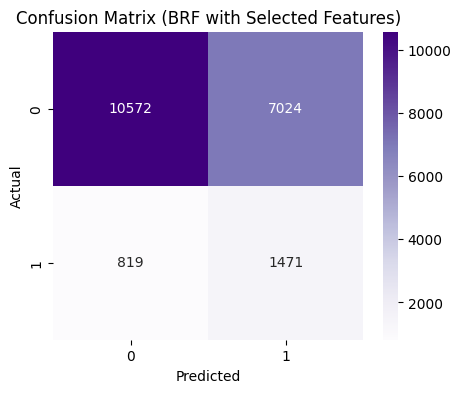

ROC AUC Score (BRF with Selected Features): 0.6711


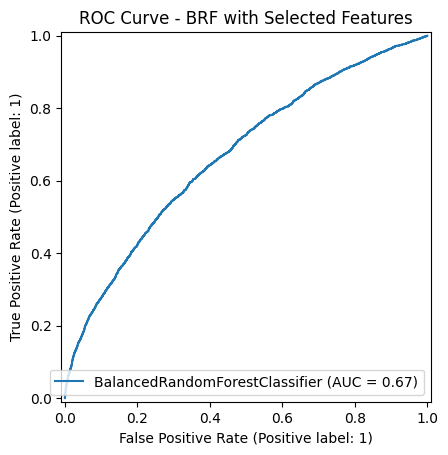

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train a new BalancedRandomForestClassifier with the best parameters
# on the selected features
brf_selected = BalancedRandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_features=grid_search.best_params_['max_features'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42,
    n_jobs=-1,
    sampling_strategy='auto'
)
brf_selected.fit(X_train_selected, y_train)

# Make predictions on the transformed test set
y_pred_brf_selected = brf_selected.predict(X_test_selected)
y_prob_brf_selected = brf_selected.predict_proba(X_test_selected)[:, 1]

# Print classification report
print("=== Classification Report (BRF with Selected Features) ===")
print(classification_report(y_test, y_pred_brf_selected, digits=4))

# Print Confusion Matrix
print("=== Confusion Matrix (BRF with Selected Features) ===")
cm_brf_selected = confusion_matrix(y_test, y_pred_brf_selected)
print(cm_brf_selected)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_brf_selected, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (BRF with Selected Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate and print ROC AUC Score
roc_auc_brf_selected = roc_auc_score(y_test, y_prob_brf_selected)
print(f"ROC AUC Score (BRF with Selected Features): {roc_auc_brf_selected:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(brf_selected, X_test_selected, y_test)
plt.title("ROC Curve - BRF with Selected Features")
plt.show()


The number of features was reduced from 110 to 55, effectively halving the dimensionality of the dataset.

The top 10 most important features identified were:

1. *number_inpatient*
2. *discharge_disposition_Discharged to home*
3. *num_medications*  
4. *discharge_disposition_Discharged/transferred to another rehab facility*
5. *time_in_hospital*
6. *number_emergency*  
7. *num_lab_procedures*  
8. *number_diagnoses*  
9. *age*  
10. *discharge_disposition_Discharged/transferred to SNF*  

The most influential variable is the number of previous inpatient visits (number_inpatient), which aligns with clinical intuition: patients with frequent prior hospitalizations are more likely to be readmitted.

Several discharge-related variables also appear among the most important features, suggesting that post-discharge destination and care setting play a relevant role in readmission risk.

Despite the substantial dimensionality reduction, model performance did not significantly improve.

This suggests that while many variables contribute marginally to the model, removing lower-importance features does not uncover stronger predictive structure.

The limitation therefore appears to be related to intrinsic data separability rather than feature redundancy.


In [ ]:
#THRESHOLD OPTIMIZATION

from sklearn.metrics import precision_recall_curve
import numpy as np

# Get precision, recall, and thresholds for the best BRF model
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_best_brf)

# Find the optimal threshold that maximizes recall
# For simplicity, let's find the threshold that gives the highest recall
# while maintaining a certain level of precision, or just highest recall

# Option 1: Maximize recall for a minimum precision (e.g., precision > 0.15)
# You can adjust this 'min_precision' based on domain knowledge
min_precision = 0.15

# Filter for thresholds where precision is above the minimum
relevant_thresholds_indices = np.where(precision >= min_precision)[0]

if len(relevant_thresholds_indices) > 0:
    # Find the index that yields the maximum recall among relevant thresholds
    optimal_index = relevant_thresholds_indices[np.argmax(recall[relevant_thresholds_indices])]
    optimal_threshold = thresholds[optimal_index]
    recall_opt = recall[optimal_index]
    precision_opt = precision[optimal_index]
else:
    # Fallback if no threshold meets the minimum precision, or simply take the one with highest recall
    print("No threshold found that satisfies the minimum precision. Selecting threshold for maximum recall.")
    optimal_index = np.argmax(recall)
    optimal_threshold = thresholds[optimal_index]
    recall_opt = recall[optimal_index]
    precision_opt = precision[optimal_index]


print("Optimal threshold:", optimal_threshold)
print("Recall at optimal threshold:", recall_opt)
print("Precision at optimal threshold:", precision_opt)


Optimal threshold: 0.451669216781878
Recall at optimal threshold: 0.7860262008733624
Precision at optimal threshold: 0.15


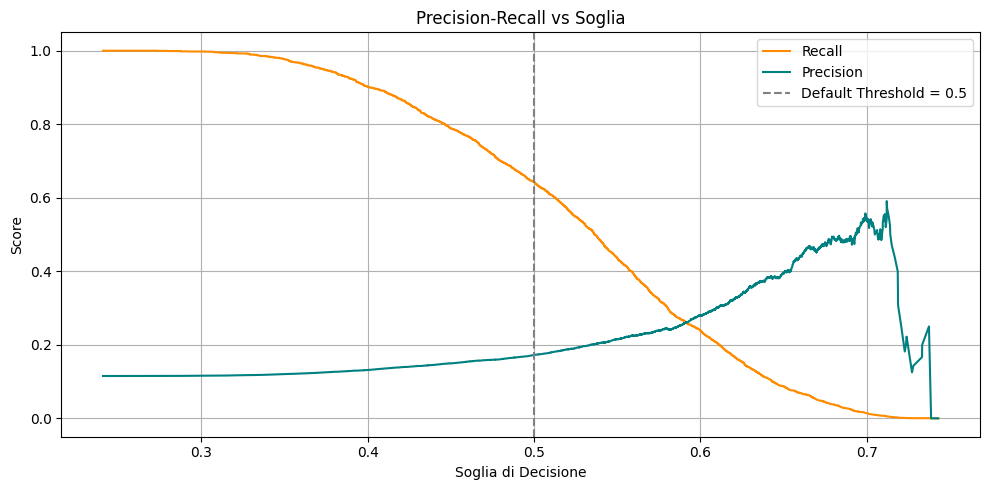


Risultati con soglia personalizzata = 0.45
              precision    recall  f1-score   support

           0     0.9379    0.4164    0.5767     17596
           1     0.1495    0.7882    0.2513      2290

    accuracy                         0.4592     19886
   macro avg     0.5437    0.6023    0.4140     19886
weighted avg     0.8471    0.4592    0.5393     19886

Recall finale: 0.7882096069868996
Precisione finale: 0.14949478217657777


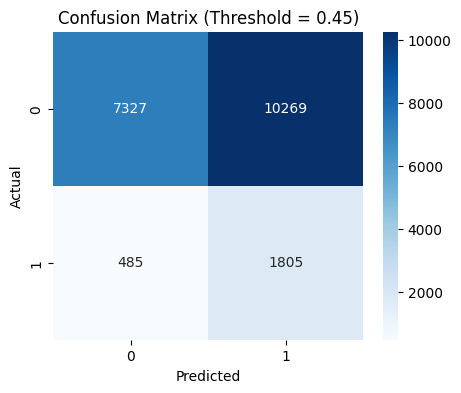

In [ ]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Using probabilities from the best_brf model
y_scores = y_prob_best_brf

# === 1. Curva Precision-Recall ===
prec, rec, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, rec[:-1], label='Recall', color='darkorange')
plt.plot(thresholds, prec[:-1], label='Precision', color='teal')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold = 0.5')
plt.xlabel("Soglia di Decisione")
plt.ylabel("Score")
plt.title("Precision-Recall vs Soglia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Imposta nuova soglia decisionale ===
custom_threshold = 0.45  # <--- You can change this to test different thresholds
y_pred_custom = (y_scores >= custom_threshold).astype(int)

# === 3. Risultati finali con soglia personalizzata ===
print(f"\nRisultati con soglia personalizzata = {custom_threshold}")
print(classification_report(y_test, y_pred_custom, digits=4))
print("Recall finale:", recall_score(y_test, y_pred_custom))
print("Precisione finale:", precision_score(y_test, y_pred_custom))

# === 4. Confusion Matrix con soglia personalizzata ===
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {custom_threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The optimal threshold identified was approximately 0.45.

At this threshold, the model achieved:

- Recall (Class 1): 0.7860 - 0.7882  
- F1-score (Class 1): ~0.2513  
- Precision (Class 1): ~0.15  
- Accuracy: 0.4592  

Lowering the threshold significantly increased recall for the minority class, allowing the model to correctly identify nearly 79% of 30-day readmissions.

However, this improvement comes at a substantial cost in precision. Only about 15% of predicted readmissions are true positives, meaning that a large number of patients are incorrectly flagged as high-risk.

The confusion matrix confirms this behavior: while true positives increase, false positives rise dramatically, reducing overall accuracy to 45.9%.

This experiment highlights the intrinsic trade-off between recall and precision in imbalanced classification problems.

While threshold adjustment can mechanically increase sensitivity, it does not improve the model’s underlying discriminative power (AUC remains unchanged). Instead, it shifts the operating point along the ROC curve.

From a practical perspective, such a high false-positive rate may limit clinical usability, as an excessive number of patients would be classified as high-risk, potentially leading to unnecessary interventions and resource allocation.

Threshold optimization improves sensitivity but does not fundamentally resolve the dataset’s limited predictive separability. The trade-off observed further supports the conclusion that model performance is primarily constrained by the intrinsic information content of the available features.



# Problem Reformulation

Given the modest performance obtained in the binary classification task (30-day readmission vs others), we explored alternative problem formulations to assess whether predictive performance could be improved.

### 1. Binary Reformulation: Readmitted vs Not Readmitted

Instead of focusing exclusively on 30-day readmission (<30), we reformulated the problem as:
- 1, for Any readmission (<30 or >30)
- 0, for No readmission

This formulation reduces class imbalance and simplifies the prediction task.

### 2. Multiclass Classification

We also reformulated the task as a three-class classification problem:
- 0, for No readmission
- 1, for Readmitted within 30 days
- 2, for Readmitted after 30 days

This approach aims to capture more granular patterns in readmission timing.


Mounted at /content/drive
Shape of diabete_adj after removing specified discharge dispositions: (99343, 53)
Shape of diabete_adj after removing rows with NaN in 'gender': (99340, 46)


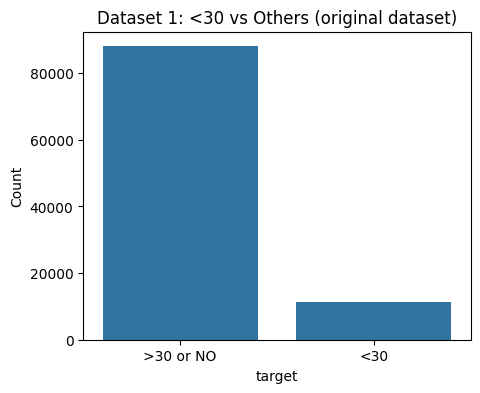

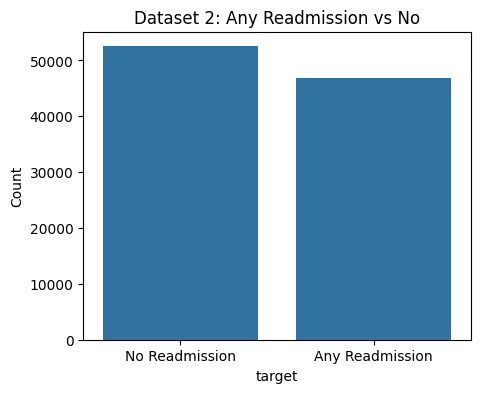

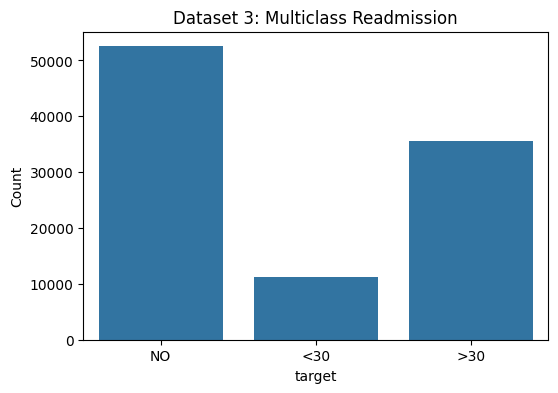

Dataset 1 distribution:
target
0    0.886108
1    0.113892
Name: proportion, dtype: float64

Dataset 2 distribution:
target
0    0.52873
1    0.47127
Name: proportion, dtype: float64

Dataset 3 distribution:
target
0    0.528730
2    0.357379
1    0.113892
Name: proportion, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import csv file
diabete = pd.read_csv("diabetic_data.csv")

# ##########################################
# Dataset Union
# ##########################################
with open("IDS_mapping.csv", "r") as f:
    lines = f.readlines()
# Isolate relevant blocks based on file structure
admission_lines = lines[1:9]
discharge_lines = lines[11:41]
source_lines = lines[43:]

# Function to create a dictionary ignoring 'NULL' descriptions
def parse_lines_to_dict(block_lines):
    mapping = {}
    for line in block_lines:
        if ',' in line:
            parts = line.strip().split(',', 1)
            if parts[0].strip().isdigit():
                descr = parts[1].strip()
                if descr != 'NULL':
                    mapping[int(parts[0])] = descr
    return mapping

admission_map = parse_lines_to_dict(admission_lines)
discharge_map = parse_lines_to_dict(discharge_lines)
source_map = parse_lines_to_dict(source_lines)

# Apply substitution in the DataFrame
diabete['admission_type'] = diabete['admission_type_id'].map(admission_map)
diabete['discharge_disposition'] = diabete['discharge_disposition_id'].map(discharge_map)
diabete['admission_source'] = diabete['admission_source_id'].map(source_map)

discharge_ids_to_remove = [11, 13, 14, 19, 20, 21]
# Get the corresponding 'discharge_disposition' values from the discharge_map
discharge_values_to_remove = [discharge_map[id] for id in discharge_ids_to_remove if id in discharge_map]
# Remove rows where 'discharge_disposition' is in the list of values to remove
diabete = diabete[~diabete['discharge_disposition'].isin(discharge_values_to_remove)].copy()
print("Shape of diabete_adj after removing specified discharge dispositions:", diabete.shape)

# Delete the original ID columns
diabete = diabete.drop(columns=[
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'
])

# Keep only the first admission per patient
#diabete = diabete.sort_values(by=['patient_nbr', 'encounter_id'])
#diabete = diabete.drop_duplicates(subset='patient_nbr', keep='first')
#print("Prendendo solo il primo ricovero per pz:", diabete.shape)

######################################################
# REPLACE
######################################################
diabete.replace('?', np.nan, inplace=True)
diabete.replace("Not Available", np.nan, inplace=True)
diabete.replace("Unknown/Invalid", np.nan, inplace=True)
diabete.replace("Not Mapped", np.nan, inplace=True)

# ###################################################################
# HANDLING MISSING VALUES
# ###################################################################

# It is definitely worth removing columns that have a high number of missing values
diabete_adj = diabete.drop(columns=['weight', 'max_glu_serum', 'A1Cresult'])

diabete_adj = diabete_adj.drop(columns=['payer_code'])

# keeping medical specialty instead, replacing the values
diabete_adj['medical_specialty'] = diabete_adj['medical_specialty'].fillna('Other')

# We now manage columns with few missing values
diabete_adj['admission_type'] = diabete_adj['admission_type'].fillna('Unknown')
diabete_adj['discharge_disposition'] = diabete_adj['discharge_disposition'].fillna('Unknown')
diabete_adj['admission_source'] = diabete_adj['admission_source'].fillna('Unknown')
diabete_adj['diag_1'] = diabete_adj['diag_1'].fillna('Unknown')
diabete_adj['diag_2'] = diabete_adj['diag_2'].fillna('Unknown')
diabete_adj['diag_3'] = diabete_adj['diag_3'].fillna('Unknown')
# Replacing missing values with 'other' for the 'race' column
diabete_adj['race']=diabete_adj['race'].fillna('Other')
# removing rows whose gender value is nan
diabete_adj.dropna(subset=['gender'], inplace=True)
print("Shape of diabete_adj after removing rows with NaN in 'gender':", diabete_adj.shape)

# <30 vs OTHERS
df_target1 = diabete_adj.copy()
df_target1['target'] = df_target1['readmitted'].apply(
    lambda x: 1 if x == '<30' else 0
)
df_target1 = df_target1.drop(columns=['readmitted'])
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df_target1)
plt.title("Dataset 1: <30 vs Others (original dataset)")
plt.xticks([0,1], ['>30 or NO', '<30'])
plt.ylabel("Count")
plt.show()

# READMITTED <30 AND >30 vs NO
df_target2 = diabete_adj.copy()
df_target2['target'] = df_target2['readmitted'].apply(
    lambda x: 0 if x == 'NO' else 1
)
df_target2 = df_target2.drop(columns=['readmitted'])
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df_target2)
plt.title("Dataset 2: Any Readmission vs No")
plt.xticks([0,1], ['No Readmission', 'Any Readmission'])
plt.ylabel("Count")
plt.show()

# MULTICLASS CLASSIFICATION
df_target3 = diabete_adj.copy()
mapping = {
    'NO': 0,
    '<30': 1,
    '>30': 2
}
df_target3['target'] = df_target3['readmitted'].map(mapping)
df_target3 = df_target3.drop(columns=['readmitted'])
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df_target3)
plt.title("Dataset 3: Multiclass Readmission")
plt.xticks([0,1,2], ['NO', '<30', '>30'])
plt.ylabel("Count")
plt.show()


print("Dataset 1 distribution:")
print(df_target1['target'].value_counts(normalize=True))

print("\nDataset 2 distribution:")
print(df_target2['target'].value_counts(normalize=True))

print("\nDataset 3 distribution:")
print(df_target3['target'].value_counts(normalize=True))



The three problem formulations exhibit markedly different class distributions.

In the original binary formulation (<30 vs others), the positive class represents only 11.4% of observations, confirming the strong imbalance that characterizes the initial task (as we had already seen before).

The alternative binary formulation (any readmission vs no readmission) is substantially more balanced, with approximately 47% positive cases. This setting appeared promising, as reduced class imbalance often facilitates improved model learning and stability.

In the multiclass setting, however, the distribution remains highly skewed, with the <30 class representing only 11.4% of the data, while the majority class (NO readmission) accounts for 52.9%.

In the multiclass configuration, model performance deteriorated significantly.
The minority class (<30) proved particularly difficult to separate from the other two categories, leading to unstable predictions and poor overall discrimination.

The overlapping nature of the >30 and <30 classes suggests limited separability in the feature space, making fine-grained temporal prediction of readmission particularly challenging.

The binary reformulation (any readmission vs no readmission) yielded more encouraging results.

With a more balanced class distribution (47% positive), the model achieved:

- Accuracy: 0.5914
- ROC-AUC: 0.6754
- F1-score (positive class): 0.6528
- Recall (positive class): 0.8174

The model demonstrates strong recall (0.8174) for readmitted patients, indicating that most readmissions are correctly identified.

However, precision remains moderate (0.5434), meaning that a substantial number of false positives are still generated. The confusion matrix confirms this trade-off, with 6,419 non-readmitted patients incorrectly predicted as readmitted.

Despite these improvements compared to the <30-only formulation, the ROC-AUC (0.6754) remains within the same performance range observed across previous experiments.

This suggests that while reducing class imbalance improves stability and recall, the overall discriminative capacity of the dataset remains limited.

The reformulated task confirms that predictive limitations are not solely driven by class imbalance. Even under more balanced conditions, model performance remains moderate, reinforcing the hypothesis that the dataset contains limited separable signal for hospital readmission prediction.

Hospital readmission is likely influenced by external factors not captured in structured hospital data, such as post-discharge care quality, social determinants of health, and patient adherence behaviors.
